## Import Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.arima.model import ARIMA
import itertools
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output



## Data Loading

In [15]:
file_path = '/home/pc/Desktop_linux/chinu/intellimark/Assigment-2-Associate-DS/Assigment-2-Associate-DS/Assessment-2-Associate-DS.csv'
df = pd.read_csv(file_path)
df.head()

,weekend_date,channel,brand,category,sub_category,EAN,quantity
0,2022-06-04,Channel1,B1,Body,Body Lotion,8906087773818,56.0
1,2022-06-11,Channel1,B1,Body,Body Lotion,8906087773818,122.0
2,2022-06-18,Channel1,B1,Body,Body Lotion,8906087773818,102.0
3,2022-06-25,Channel1,B1,Body,Body Lotion,8906087773818,128.0
4,2022-07-02,Channel1,B1,Body,Body Lotion,8906087773818,97.0


In [16]:
df['EAN'].value_counts()

EAN
8906087773818    118
8904417301076    110
8906087779247    109
8904417301106    106
8904417305838     85
8904417306248     72
Name: count, dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   weekend_date  600 non-null    object 
 1   channel       600 non-null    object 
 2   brand         600 non-null    object 
 3   category      600 non-null    object 
 4   sub_category  600 non-null    object 
 5   EAN           600 non-null    int64  
 6   quantity      600 non-null    float64
dtypes: float64(1), int64(1), object(5)
memory usage: 32.9+ KB


In [18]:
# Convert datatype of date column
df['weekend_date'] = df['weekend_date'].apply(lambda x: pd.to_datetime(x.split(' ')[0]))
df['month_number'] = df['weekend_date'].dt.month + df['weekend_date'].dt.year * 12  
df = df.sort_values(by='weekend_date', ascending=True).reset_index(drop=True)
df.head()

,weekend_date,channel,brand,category,sub_category,EAN,quantity,month_number
0,2022-05-28,Channel2,B1,Face,Face Serum,8906087779247,203.0,24269
1,2022-06-04,Channel2,B1,Face,Face Serum,8906087779247,198.0,24270
2,2022-06-04,Channel1,B1,Body,Body Lotion,8906087773818,56.0,24270
3,2022-06-11,Channel2,B1,Face,Face Serum,8906087779247,188.0,24270
4,2022-06-11,Channel1,B1,Body,Body Lotion,8906087773818,122.0,24270


In [19]:
# Create small dataframe for given 'EAN' -  product identifier
def create_small_dataframe(df, product_id):
    small_df = df[df['EAN'] == product_id]
    small_df = small_df.reset_index(drop=True)
    start_date = small_df['weekend_date'].min()
    small_df['weekend_number'] = small_df['weekend_date'].apply(lambda x: ((x - start_date).days // 7) + 1)
    small_df = fix_missing_values_ifany(small_df)
    return small_df


def fix_missing_values_ifany(small_df):
    ''' 
    need to check all the 'weekend_number' are consecutive.
    '''
    small_df['diff_weekend'] = small_df['weekend_number'].diff()
    small_df.loc[0, 'diff_weekend'] = 1    
    if (small_df['diff_weekend'] != 1).sum() != 0:
        small_df = add_missing_rows(small_df)
    return small_df


def add_missing_rows(small_df):
    missing_row_df = small_df[small_df['diff_weekend'] != 1]
    print(f'There are missing values, added {missing_row_df.shape[0]} row in dataframe')
    for i in missing_row_df.index[::-1] :
        new_row = {
                    'weekend_date': [small_df.loc[i, 'weekend_date'] - pd.Timedelta(days=7)],
                    'channel': [small_df.loc[i, 'channel']],
                    'brand': [small_df.loc[i, 'brand']],
                    'category': [small_df.loc[i, 'category']],
                    'sub_category': [small_df.loc[i, 'sub_category']],
                    'EAN': [small_df.loc[i, 'EAN']],
                    'quantity': [(small_df.loc[i, 'quantity'] + small_df.loc[i - 1, 'quantity']) // 2],
                    'month_number': [small_df.loc[i, 'month_number']],
                    'weekend_number': [small_df.loc[i, 'weekend_number'] - 1],
                    'diff_weekend': [small_df.loc[i, 'diff_weekend'] - 1]
                }
        new_row_df = pd.DataFrame(new_row)
        new_row_df['month_number'] = new_row_df['weekend_date'].dt.month + new_row_df['weekend_date'].dt.year * 12  
        df_before = small_df.iloc[:i]
        df_after = small_df.iloc[i:]
        small_df = pd.concat([df_before, new_row_df, df_after], axis=0)
        small_df = small_df.reset_index(drop=True)
    return small_df


def visualize(small_df):
    plt.figure(figsize=(8,2))
    sns.lineplot(data=small_df, x='weekend_number', y='target')
    plt.xticks(rotation=90)
    plt.title(small_df.loc[0, 'EAN'])
    num_ticks = small_df.shape[0] // 5
    xticks_positions = np.linspace(small_df['weekend_number'].min(), small_df['weekend_number'].max(), num_ticks, dtype=int)
    plt.xticks(xticks_positions)
    plt.show()
    
    plt.figure(figsize=(5,2))
    sns.boxplot(data=small_df, x='quantity')
    plt.show()
    
def ADF_test(data, IS_STATIONARY):
    results = adfuller(data)
    p_val = results[1]
    if p_val < 0.05:
        print(f'*** It is a Stationary Data ( P-value is {p_val} ) ***')
        print('Data is ready for Model Building')
        IS_STATIONARY = True
    else:
        print(f'It is a non-stationary data ( P-value is {p_val} )')
    return IS_STATIONARY


In [20]:
def make_stationary(data, method, IS_STATIONARY):
    """
    Transforms time series data to make it stationary.
    """
    try:
        if method == 'differencing':
            stationary_data = data.diff().dropna()  # First-order differencing
        elif method == 'log_differencing':
            stationary_data = np.log(data).diff().dropna() # Log transform, then differencing
        elif method == 'seasonal_differencing':
            seasonal_period = find_seasonal_period(data) # Find seasonal period
            if seasonal_period is None:
                print("Could not find seasonal period. Please specify manually.")
                return None
            stationary_data = data.diff(seasonal_period).dropna() # Seasonal differencing
        else:
            print("Invalid method. Choose from 'differencing', 'log_differencing', or 'seasonal_differencing'.")
            return None

        # Check stationarity using ADF test
        IS_STATIONARY = ADF_test(stationary_data, IS_STATIONARY) 
        return stationary_data, IS_STATIONARY

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def find_seasonal_period(data):
    """
    Attempts to find the seasonal period of a time series.
    """
    try:
        from statsmodels.tsa.seasonal import seasonal_decompose
        decomposition = seasonal_decompose(data, model='additive', extrapolate_trend='freq', period = int(len(data)/2)) #period is set to half the length of data, if it can not be detected.
        seasonal = decomposition.seasonal
        seasonal_period = seasonal.index.freq.n if seasonal.index.freq else None
        return seasonal_period
    except:
        return None

product is 8906087779247
There are missing values, added 1 row in dataframe
*** It is a Stationary Data ( P-value is 5.872551985060542e-13 ) ***
Data is ready for Model Building


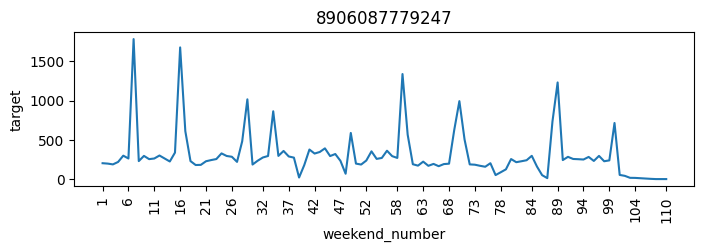

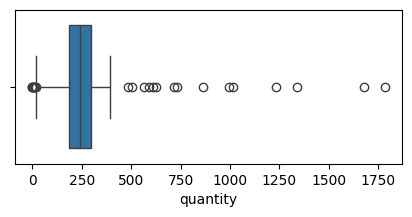

____________________________________________________________________________________________________


In [21]:
for product_id in df['EAN'].unique():
    IS_STATIONARY = False
    product_id = 8906087779247
    print(f'product is {product_id}')

    small_df = create_small_dataframe(df, product_id)

    IS_STATIONARY = ADF_test(small_df['quantity'], IS_STATIONARY)
    small_df['target'] = small_df['quantity']
    
    if IS_STATIONARY == False:
        count = 1
        methods = ['differencing', 'log_differencing', 'seasonal_differencing']
        while count < 3:
            method = methods[count - 1]
            print(f'\nSome Transformation is required.. Trying {method} method on data')
            stationary_data, IS_STATIONARY = make_stationary(small_df[['quantity']], method, IS_STATIONARY)
            count += 1
            if IS_STATIONARY == True:
                break
        small_df = small_df.iloc[1:]
        small_df = small_df.reset_index(drop=True)
        small_df['target'] = stationary_data
        print('Data after transformation')
        
    visualize(small_df)

    small_df.set_index('weekend_date', inplace=True)

    print("__" * 50)

    break


In [22]:
small_df.head()

,channel,brand,category,sub_category,EAN,quantity,month_number,weekend_number,diff_weekend,target
weekend_date,,,,,,,,,,
2022-05-28,Channel2,B1,Face,Face Serum,8906087779247,203.0,24269,1,1.0,203.0
2022-06-04,Channel2,B1,Face,Face Serum,8906087779247,198.0,24270,2,1.0,198.0
2022-06-11,Channel2,B1,Face,Face Serum,8906087779247,188.0,24270,3,1.0,188.0
2022-06-18,Channel2,B1,Face,Face Serum,8906087779247,219.0,24270,4,1.0,219.0
2022-06-25,Channel2,B1,Face,Face Serum,8906087779247,299.0,24270,5,1.0,299.0


## Product = 8906087779247

In [23]:
def acf_and_pacf(data):
    plt.figure(figsize=(3,2))
    plot_acf(data['target'], lags=50, zero=False)
    plt.show()
    plt.figure(figsize=(3,2))
    plot_pacf(data['target'], lags=50, zero=False)
    plt.show()

<Figure size 300x200 with 0 Axes>

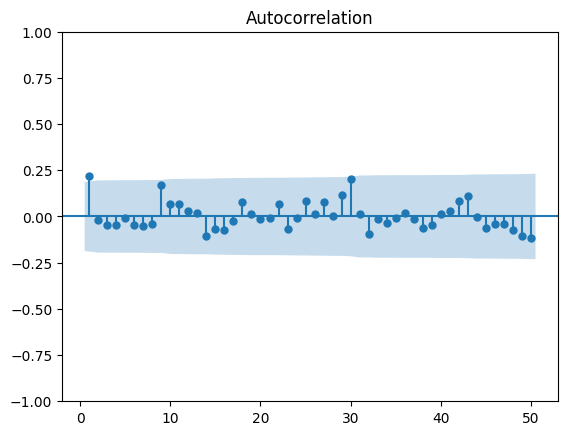

<Figure size 300x200 with 0 Axes>

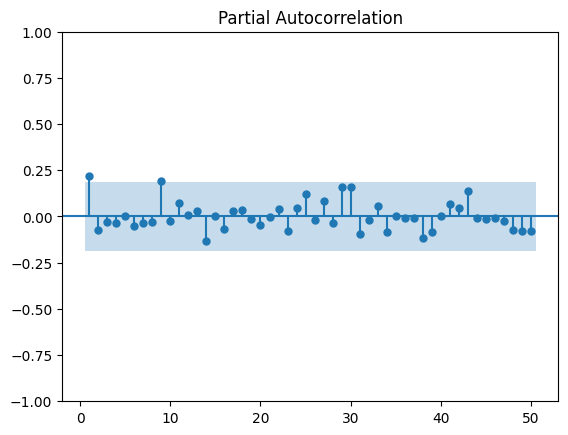

In [24]:
acf_and_pacf(small_df)

In [25]:
def split_train_test(data, num_last_months):
    last_month = data['month_number'].max()
    train_size = data[data['month_number'] <= (last_month - num_last_months)].shape[0]
    train_df = data[:train_size]
    test_df = data[train_size:]
    return train_df, test_df

def get_accuracy(data, results):
    data['predictions'] = results
    data['pred_ratio'] = abs(data['predictions'] - data['quantity']) / data['quantity']
    agg = pd.DataFrame({})

    agg['accuracy'] = 1 - data.groupby(by='month_number')['pred_ratio'].sum()
    return agg

In [37]:
small_df['target']

weekend_date
2022-05-28    203.0
2022-06-04    198.0
2022-06-11    188.0
2022-06-18    219.0
2022-06-25    299.0
              ...  
2024-06-01      8.0
2024-06-08      4.0
2024-06-15      1.0
2024-06-22      1.0
2024-06-29      1.0
Name: target, Length: 110, dtype: float64

In [36]:

p_values = d_values = q_values = range(0, 3)  # Example ranges
P_values = D_values = Q_values = range(0, 2)
s = [10, 11, 12] #seasonal period for weekly data

best_aic = float("inf")
best_order = None
best_seasonal_order = None
train_df, test_df = split_train_test(small_df, 3)
best_acc = -1 * float("inf")
count = 1

for p, d, q, P, D, Q, s in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s):
    print('trying .. ', p, d, q, P, D, Q, s)

    try:
        model = SARIMAX(small_df['target'], order=(p, d, q), seasonal_order=(P, D, Q, s))
        results = model.fit(disp=False)
        predictions = results.fittedvalues

        # Out-of-sample predictions (test data)
        forecast = results.get_forecast(steps=test_df.shape[0])
        test_predictions = forecast.predicted_mean
        monthly_acc = get_accuracy(test_df['quantity'], test_predictions)
        acc = monthly_acc['accuracy'].sum()


        # if results.aic < best_aic:
        if acc > best_acc:
            best_aic = results.aic
            best_order = (p, d, q)
            best_seasonal_order = (P, D, Q, s)
            best_model = model
            best_results = results
            best_acc = acc
            break
    except:
        print('      raised exception, continueing')
        count += 1
        if count < 100:
            continue
        else:
            break

print(f"Best AIC: {best_aic}")
print(f"Best Order: {best_order}")
print(f"Best Seasonal Order: {best_seasonal_order}")

trying ..  0 0 0 0 0 0 10
      raised exception, continueing
trying ..  0 0 0 0 0 0 11
      raised exception, continueing
trying ..  0 0 0 0 0 0 12
      raised exception, continueing
trying ..  0 0 0 0 0 1 10
      raised exception, continueing
trying ..  0 0 0 0 0 1 11
      raised exception, continueing
trying ..  0 0 0 0 0 1 12
      raised exception, continueing
trying ..  0 0 0 0 1 0 10
      raised exception, continueing
trying ..  0 0 0 0 1 0 11
      raised exception, continueing
trying ..  0 0 0 0 1 0 12
      raised exception, continueing
trying ..  0 0 0 0 1 1 10
      raised exception, continueing
trying ..  0 0 0 0 1 1 11
      raised exception, continueing
trying ..  0 0 0 0 1 1 12
      raised exception, continueing
trying ..  0 0 0 1 0 0 10
      raised exception, continueing
trying ..  0 0 0 1 0 0 11
      raised exception, continueing
trying ..  0 0 0 1 0 0 12
      raised exception, continueing
trying ..  0 0 0 1 0 1 10
      raised exception, continueing
trying .

In [ ]:
model = ARIMA(data, order=(2, 0, 3))
results = model.fit()
predictions = results.fittedvalues

residuals = results.resid
plt.plot(residuals, color='r')
plt.plot(small_df['quantity'], color='g')
plt.plot(predictions, color='b')
plt.show()

## Sarimax

In [ ]:
import itertools
import warnings
warnings.filterwarnings("ignore") #suppress warnings for cleaner output.

p_values = d_values = q_values = range(0, 3)  # Example ranges
P_values = D_values = Q_values = range(0, 2)
s = range(10, 14) #seasonal period for weekly data

best_aic = float("inf")
best_order = None
best_seasonal_order = None

for p, d, q, P, D, Q, s in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s):
    # print('trying .. ', p, d, q, P, D, Q, s)
    try:
        model = SARIMAX(small_df['log_quantity'], order=(p, d, q), seasonal_order=(P, D, Q, s))
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p, d, q)
            best_seasonal_order = (P, D, Q, s)
            best_model = model
            best_results = results
    except:
        continue

print(f"Best AIC: {best_aic}")
print(f"Best Order: {best_order}")
print(f"Best Seasonal Order: {best_seasonal_order}")


In [ ]:
best_model = SARIMAX(small_df['log_quantity'], order=(5,1,2), seasonal_order=(1,0,0,12))
best_results = best_model.fit(disp=False)
print(best_results.summary())

In [ ]:
# In-sample predictions (training data)
train_predictions = best_results.fittedvalues

residuals = best_results.resid
plt.plot(residuals, color='r')
plt.plot(small_df['log_quantity'], color='g')
plt.plot(train_predictions, color='b')
plt.show()

In [ ]:
res = (10 ** train_predictions) - small_df['quantity']

plt.plot(res, color='r')
plt.plot(small_df['quantity'], color='g')
plt.plot(10 ** train_predictions, color='b')
plt.show()

In [ ]:


def evaluate_arima_model(data, order, seasonal_order, test_size=0.2):
    """
    Evaluates an ARIMA/SARIMAX model and calculates accuracy measures.

    Args:
        data (pd.Series): The time series data.
        order (tuple): The (p, d, q) order of the model.
        seasonal_order (tuple): The (P, D, Q, s) seasonal order of the model.
        test_size (float): The proportion of the data to use as the test set.

    Returns:
        dict: A dictionary containing the accuracy measures.
    """

    try:
        # Split data into train and test sets
        train_size = int(len(data) * (1 - test_size))
        train, test = data[:train_size], data[train_size:]

        # Fit the model
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)

        # In-sample predictions (training data)
        train_predictions = results.fittedvalues

        # Out-of-sample predictions (test data)
        forecast = results.get_forecast(steps=len(test))
        test_predictions = forecast.predicted_mean

        # Calculate accuracy measures
        train_rmse = np.sqrt(mean_squared_error(train, train_predictions))
        train_mae = mean_absolute_error(train, train_predictions)

        test_rmse = np.sqrt(mean_squared_error(test, test_predictions))
        test_mae = mean_absolute_error(test, test_predictions)

        # Residual analysis (Ljung-Box test)
        residuals = results.resid
        lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True) # Check for autocorrelation up to lag 10.
        lb_pvalue = lb_test['lb_pvalue'].values[0]

        #Return results
        return {
            "train_rmse": train_rmse,
            "train_mae": train_mae,
            "test_rmse": test_rmse,
            "test_mae": test_mae,
            "aic": results.aic,
            "bic": results.bic,
            "lb_pvalue": lb_pvalue,
            "residuals": residuals,
            "train_predictions": train_predictions,
            "test_predictions": test_predictions,
            "test_actual": test,
            "train_actual": train
        }

    except Exception as e:
        print(f"An error occurred: {e}")
        return None



# Example usage (replace with your actual data and parameters):
# Assuming your time series data is in a pandas Series called 'time_series_data'

# Create sample data.
data = {'target_variable': [10, 12, 15, 18, 20, 22, 25, 28, 30, 32, 35, 38, 40,42,45,48,50,52,55,58,60,62,65,68,70,72,75,78,80,82,85,88,90,92,95,98,100,102,105,108,110,112,115,118,120,122,125,128,130,132,135,138]}
time_series_data = pd.Series(data['target_variable'])

# Define the order and seasonal order (you'll need to determine these based on your data).
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Evaluate the model
results = evaluate_arima_model(time_series_data, order, seasonal_order)

if results:
    print(f"Train RMSE: {results['train_rmse']:.4f}")
    print(f"Train MAE: {results['train_mae']:.4f}")
    print(f"Test RMSE: {results['test_rmse']:.4f}")
    print(f"Test MAE: {results['test_mae']:.4f}")
    print(f"AIC: {results['aic']:.4f}")
    print(f"BIC: {results['bic']:.4f}")
    print(f"Ljung-Box p-value: {results['lb_pvalue']:.4f}")

    # Plot residuals
    plt.figure(figsize=(10, 4))
    plt.plot(results['residuals'])
    plt.title("Residuals")
    plt.show()

    #Plot predictions vs actual
    plt.figure(figsize=(10,6))
    plt.plot(results['train_actual'], label='Train Actual')
    plt.plot(results['train_predictions'], label = "Train Predicted")
    plt.plot(results['test_actual'], label='Test Actual')
    plt.plot(results['test_predictions'], label = "Test Predicted")
    plt.legend()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm

def tune_sarimax(series, seasonal_period):
    """Tunes SARIMAX model using grid search and AIC."""

    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]

    best_aic = float("inf")
    best_params = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(series, order=param, seasonal_order=param_seasonal)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = (param, param_seasonal)
            except:
                continue

    return best_params

def sarimax_forecast(series, order, seasonal_order, forecast_steps):
    """Fits SARIMAX model and generates forecasts."""
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=forecast_steps)
    forecast_values = forecast.predicted_mean
    return forecast_values

def auto_sarimax_forecast(series, seasonal_period, forecast_steps):
    """Fits SARIMAX model using auto_arima and generates forecasts."""
    model = pm.auto_arima(series, seasonal=True, m=seasonal_period, suppress_warnings=True)
    forecast = model.predict(n_periods=forecast_steps)
    return forecast

# Example usage (assuming your data is in 'sales_data.csv')
df = pd.read_csv('sales_data.csv')
df['weekend date'] = pd.to_datetime(df['weekend date'])
df.set_index('weekend date', inplace=True) #set index to date

# Example: Forecasting for a specific product ID
product_id = df['product ID'].unique()[0] #get first product ID
product_series = df[df['product ID'] == product_id]['quantity']

seasonal_period = 52  # Example: Weekly data with yearly seasonality

# 1. Tuning with Grid Search and AIC
best_params = tune_sarimax(product_series, seasonal_period)
if best_params:
    order, seasonal_order = best_params
    print(f"Best SARIMAX parameters (Grid Search): order={order}, seasonal_order={seasonal_order}")

    # Split data for evaluation
    train_size = int(len(product_series) * 0.8)
    train, test = product_series[:train_size], product_series[train_size:]
    forecast_steps = len(test)

    # Forecast and evaluate
    forecast_values = sarimax_forecast(train, order, seasonal_order, forecast_steps)
    mae = mean_absolute_error(test, forecast_values)
    print(f"SARIMAX MAE (Grid Search): {mae}")

# 2. Tuning with auto_arima
    forecast_values_auto = auto_sarimax_forecast(train, seasonal_period, forecast_steps)
    mae_auto = mean_absolute_error(test, forecast_values_auto)
    print(f"SARIMAX MAE (auto_arima): {mae_auto}")

else:
    print("SARIMAX tuning failed.")

#Example of how to run this for all product IDs.
product_ids = df['product ID'].unique()

for product_id in product_ids:
    product_series = df[df['product ID'] == product_id]['quantity']

    best_params = tune_sarimax(product_series, seasonal_period)

    if best_params:
      order, seasonal_order = best_params
      print(f"Best SARIMAX parameters (Grid Search) for product {product_id}: order={order}, seasonal_order={seasonal_order}")

      train_size = int(len(product_series) * 0.8)
      train, test = product_series[:train_size], product_series[train_size:]
      forecast_steps = len(test)

      forecast_values = sarimax_forecast(train, order, seasonal_order, forecast_steps)
      mae = mean_absolute_error(test, forecast_values)
      print(f"SARIMAX MAE (Grid Search) for product {product_id}: {mae}")
    else:
      print(f"SARIMAX tuning failed for product {product_id}.")

In [ ]:
df.head()

In [ ]:
sns.lineplot(data=df[df['EAN'] == 8906087779247], x = 'weekend_date', y = 'quantity', color='b')
sns.lineplot(data=df[df['EAN'] == 8906087773818], x = 'weekend_date', y = 'quantity', color='r')

In [ ]:
plt.figure(figsize=(15, 10))
for product_id in df['EAN'].unique():
    sns.lineplot(data=df[df['EAN'] == product_id], x = 'weekend_date', y = 'quantity', color='b')

plt.show()

## Practice code

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Simulate realistic monthly sales data for a retail store
np.random.seed(42)  # For reproducibility

dates = pd.date_range(start='2018-01-01', end='2023-12-31', freq='MS')
years = dates.year
months = dates.month

In [ ]:
# Base sales with an upward trend
base_sales = 500 + 10 * (years - 2018) + np.random.normal(0, 50, len(dates))
base_sales
# Seasonal component (holiday spikes, summer dip)
seasonal_component = 200 * np.sin(2 * np.pi * months / 12) + 100 * np.sin(2 * np.pi * (months % 12) / 6) + np.random.normal(0, 30, len(dates))

# Random fluctuations
noise = np.random.normal(0, 80, len(dates))

# Final sales data
retail_sales = base_sales + seasonal_component + noise


In [ ]:
# Create DataFrame
data = pd.DataFrame({'sales': retail_sales}, index=dates)

In [ ]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data['sales'], label='Retail Sales')
plt.legend()
plt.title('Retail Sales Over Time')
plt.show()

In [ ]:
# Decompose the time series
decomposition = seasonal_decompose(data['sales'], model='additive')
decomposition.plot()
plt.show()


In [ ]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [ ]:
# Fit SARIMA model (parameter tuning is crucial)
# Example parameters. In real world, use auto_arima or grid search.
model = sm.tsa.SARIMAX(train['sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

In [ ]:
# Generate forecasts
forecast = results.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [ ]:
# Plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(test.index, forecast_values, label='Forecast', color='red')
plt.fill_between(test.index, confidence_intervals[:, 0], confidence_intervals[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('SARIMA Forecast vs. Actual Sales')
plt.show()

In [ ]:
# Evaluate the model (RMSE)
rmse = np.sqrt(mean_squared_error(test['sales'], forecast_values))
print(f'RMSE: {rmse}')

#Print model summary.
print(results.summary())

# Example of forecasting future values (beyond the test set)
future_dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='MS')
future_forecast = results.get_forecast(steps=len(future_dates))
future_forecast_values = future_forecast.predicted_mean
future_confidence_intervals = future_forecast.conf_int()

# Plot future forecasts
plt.figure(figsize=(12, 6))
plt.plot(data['sales'], label='Historical Sales')
plt.plot(future_dates, future_forecast_values, label='Future Forecast', color='green')
plt.fill_between(future_dates, future_confidence_intervals[:, 0], future_confidence_intervals[:, 1], color='lightgreen', alpha=0.3)
plt.legend()
plt.title('SARIMA Future Forecast')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Assuming your data is in a CSV file named 'sales_data.csv'
df = pd.read_csv('sales_data.csv')

# 1. Data Understanding and Preparation
# Convert 'weekend date' to datetime
df['weekend date'] = pd.to_datetime(df['weekend date'])

# EDA (Example: Plotting quantity over time for a specific product)
product_id = df['product ID'].unique()[0]  # Example: first product
product_df = df[df['product ID'] == product_id].sort_values('weekend date')
plt.figure(figsize=(12, 6))
plt.plot(product_df['weekend date'], product_df['quantity'])
plt.title(f'Quantity over Time for Product {product_id}')
plt.xlabel('Weekend Date')
plt.ylabel('Quantity')
plt.show()

# Feature Engineering
df['year'] = df['weekend date'].dt.year
df['month'] = df['weekend date'].dt.month
df['dayofweek'] = df['weekend date'].dt.dayofweek

# Lagged features (example: lag of 1 week)
df['quantity_lag1'] = df.groupby(['channel', 'brand', 'category', 'product ID'])['quantity'].shift(1)
df.dropna(inplace=True) #remove the first week of each group due to the shift.

# Categorical Encoding (One-Hot Encoding)
categorical_cols = ['channel', 'brand', 'category', 'product ID']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cols = pd.DataFrame(encoder.fit_transform(df[categorical_cols]))
encoded_cols.columns = encoder.get_feature_names_out(categorical_cols)
df = pd.concat([df.drop(categorical_cols, axis=1), encoded_cols], axis=1)

# Data Splitting (Chronological Split)
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

# Prepare features and target
features = [col for col in df.columns if col not in ['weekend date', 'quantity']]
target = 'quantity'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# 2. Model Selection and Training (Example: Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 3. Model Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Example using Prophet model for one specific series.
# Prepare dataframe for prophet
prophet_df = product_df[['weekend date', 'quantity']].rename(columns={'weekend date': 'ds', 'quantity': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=len(test[test['product ID_product 2.0'] == 1]), freq='W') #Example product ID_product 2.0
forecast = prophet_model.predict(future)

# Example of how to get the correct forecast period.
test_prophet = test[test['product ID_product 2.0'] == 1]
prophet_forecast_needed = forecast[forecast['ds'].isin(test_prophet['weekend date'])]
prophet_y_pred = prophet_forecast_needed['yhat'].values
prophet_y_test = test_prophet['quantity'].values

prophet_mae = mean_absolute_error(prophet_y_test, prophet_y_pred)
print(f"Prophet MAE: {prophet_mae}")

# Example ARIMA model (for one series)
product_series = product_df['quantity'].values
arima_model = ARIMA(product_series, order=(5, 1, 0)) #example order
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test[test['product ID_product 2.0'] == 1]))

arima_mae = mean_absolute_error(test_prophet['quantity'], arima_forecast)
print(f"ARIMA MAE: {arima_mae}")

# Further steps:
# - Implement time series cross-validation.
# - Experiment with other models (SARIMA, LSTM, XGBoost, etc.).
# - Fine-tune hyperparameters.
# - Handle multi-series forecasting more comprehensively.